In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm_notebook as tqdm
import os, glob, json
import config as cfg
from IPython.display import display
from ipywidgets import widgets, Layout
from module.cluster import VAE_Cluster
from module.vmt import VMT, TemplateD
from module.vae import GaussianKLLoss
from dataset import KKDayUser, seq_collate
from constant import Constants
from utils import get_fixed_temperature, get_losses
from sklearn.cluster import KMeans
import numpy as np
from tensorboardX import SummaryWriter
from utils import gradient_penalty, str2bool, chunks
from sklearn.manifold import SpectralEmbedding
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction
from shutil import copyfile
import pickle
import seaborn as sns
from collections import namedtuple

In [3]:
from sklearn.cluster import SpectralClustering
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [4]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [5]:
class Struct:
    def __init__(self, **entries):
        self.__dict__.update(entries)

In [8]:
from dataset import TemPest, tempest_collate
valid_dataset = TemPest(args.cache_path, 'valid')
print(len(valid_dataset))

eval_dataloader = torch.utils.data.DataLoader(valid_dataset, num_workers=8,
                        collate_fn=tempest_collate, batch_size=48, shuffle=True, drop_last=True)

dataset/valid.pt
1761


### Lets Visualize template first

In [62]:
# log_name = 'save/tempest_rec-2020-07-19-15-51-26'
# log_name = 'save/tempest_biset-2020-07-19-19-39-42'
log_name = 'save/tempest_biset-2020-07-22-00-22-02'
checkpoint = 'checkpoint_3000.pt'
h_dim = 500
from module.vmt import VMT
with open(os.path.join(log_name, 'params.json'), 'r') as f:
    params = json.load(f)
args = Struct(**params)
id_mapping = torch.load(os.path.join(args.cache_path, 'id_mapping.pt'))
user_size = len(id_mapping['user2id'])
user_size = user_size
prod_size = len(id_mapping['prod2id'])
id2user = { value: key for key, value in id_mapping['user2id'].items() }

model = VMT(args.gen_embed_dim, args.vocab_size,
            enc_hidden_size=h_dim, dec_hidden_size=h_dim, tmp_category=args.tmp_cat_dim,
            tmp_latent_dim=args.tmp_latent_dim, desc_latent_dim=args.desc_latent_dim, user_latent_dim=args.user_latent_dim,
            biset=args.biset, user_embedding=True, user_size=user_size,
            max_seq_len=args.max_seq_len-1, gpu=True).cuda()
model.load_state_dict(torch.load(os.path.join(log_name,checkpoint))['model'])
model = model.eval()

Generate examples

In [63]:
sentences, references = [], []
articles = []
user_id = []
temp_inputs = []
temp_latent = []; temp_outputs= []
with torch.no_grad():
    for batch in tqdm(eval_dataloader):
        src_inputs = batch['src']
        tmp = batch['tmt']
        inputs, target = batch['tgt'][:, :-1], batch['tgt'][:, 1:]
        users = batch['users']
        empty_users = users == -1
        batch_size = len(empty_users)
        users_filled = users.detach()
        users_filled[empty_users] = torch.randint(0, user_size, ( int(empty_users.sum()),  ))

        if cfg.CUDA:
            src_inputs = src_inputs.cuda()
            target = target.cuda()
            tmp = tmp.cuda()
            inputs = inputs.cuda()
            users_filled = users_filled.cuda()

        desc_outputs, desc_latent, desc_mean, desc_std = model.encode_desc(src_inputs)
        tmp_outputs, tmp_latent = model.encode_tmp(tmp)
        for latent_ in tmp_latent:
            temp_latent.append(latent_.cpu().numpy().flatten())
        for latent_ in tmp_outputs:
            temp_outputs.append(latent_.cpu().numpy())
        user_embeddings = model.user_embedding( users_filled )
        _, output_title = model.decode(tmp_latent, desc_latent, user_embeddings, 
                desc_outputs, tmp_outputs,
                max_length=target.shape[1])

        for idx, sent_token in enumerate(batch['tgt'][:, 1:]):
            reference = []
            for token in sent_token:
                if token.item() == Constants.EOS:
                    break
                reference.append(valid_dataset.tokenizer.idx2word[token.item()] )
            references.append(''.join(reference))

            sent = output_title[idx]
            sentence = []
            for token in sent:
                if token.item() == Constants.EOS:
                    break
                sentence.append(valid_dataset.tokenizer.idx2word[token.item()])
            sentences.append(''.join(sentence))

            sent = tmp[idx][1:]
            sentence = []
            for token in sent:
                if token.item() == Constants.EOS:
                    break
                sentence.append(valid_dataset.tokenizer.idx2word[token.item()])
            temp_inputs.append(''.join(sentence).replace('舊', '##'))

            
            article = []
            for token in src_inputs[idx][1:]:
                if token.item() == Constants.EOS:
                    break
                article.append(valid_dataset.tokenizer.idx2word[token.item()])
            articles.append(''.join(article))
            user_id.append(id2user[users_filled[idx].item()])

/home/theblackcat102/Documents/text-subgan/env/lib/python3.6/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


In [64]:
import json
with open(log_name.replace('/','_')+checkpoint+'.jsonl', 'w') as f:
    for idx in range(len(user_id)):
        results = {
            'generate': sentences[idx],
            'original': references[idx],
            'input_user': user_id[idx],
            'article': articles[idx],
            'template': temp_inputs[idx]
        }
        f.write(json.dumps(results)+'\n')
print(results)

{'generate': '巴塞羅出發出發一日遊', 'original': '復活島：半日考古旅遊', 'input_user': '22694598-12d7-4d18-84bf-06a7f58a5fe5', 'article': '在半日旅遊中發現復活島的奧祕。由安加羅阿出發，遊覽阿基維祭壇、</UNK>祭壇、</UNK>火山岩採石場</UNK></UNK>。行程特色•探索</UNK>國家公園聯合國教科文組織世界文化遺產•參觀</UNK>祭壇•在阿基維祭壇驚歎於七尊莫埃行程介紹遊覽被列為聯合國教科文組織世界文化遺產的復活島南邊，和參觀</UNK>祭壇。前往阿基維祭壇並發現面向赤道的朝陽的七尊莫埃。每座巨像高約16英尺和重約18噸。根據民間傳說，這7座巨像代表離開傳說中</UNK></UNK>的家園</UNK>的年輕探險家，在精神牧師豪瑪卡讓侯圖・瑪圖阿注意這個島的存在後，他們便在這個島上</UNK>。好好反思這個故事和復活', 'template': '##：加##和##石橋全日##斯山脈旅遊'}


In [65]:
X, title = [], []
print(len(temp_latent))
for idx, latent in enumerate(temp_latent):
    X.append(latent)
    title.append(references[idx])
temp_outputs = np.array(temp_outputs)
title = np.array(title)
articles = np.array(articles)
X = np.array(X)

1728


### Visualize categorical distribution of the first template latent

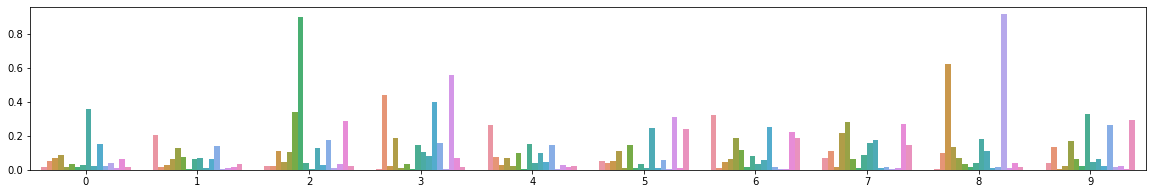

In [66]:
plt.rcParams["figure.figsize"] = (20,3)

data = {'y': [], 'bins': [], 'type': []}
for idx, latent in enumerate(X[0].reshape(args.tmp_latent_dim, args.tmp_cat_dim)):
    data['y'] += list(range(len(latent)))
    data['bins'] += list(latent)
    data['type'] += list([idx]*len(latent))
g = sns.barplot(x='y', y='bins', data=data, hue='type')
g.legend_.remove()

## Sample some latent as reference

In [67]:
with torch.no_grad():
    for idx, batch in enumerate(eval_dataloader):
        src_inputs = batch['src']
        tmp = batch['tmt']
        inputs, target = batch['tgt'][:, :-1], batch['tgt'][:, 1:]
        users = batch['users']
        non_empty_users = users != -1
        if cfg.CUDA:
            src_inputs = src_inputs[non_empty_users].cuda()
            target = target[non_empty_users].cuda()
            tmp = tmp[non_empty_users].cuda()
            inputs = inputs[non_empty_users].cuda()
            users = users[non_empty_users].cuda()

        if non_empty_users.sum() > 0 and idx > 1:
            print('found')
            break

found


In [68]:
desc_outputs, desc_latent, desc_mean, desc_std = model.encode_desc(src_inputs)
tmp_outputs, tmp_latent = model.encode_tmp(tmp)
user_embeddings = model.user_embedding( users )
_, output_title = model.decode(tmp_latent, desc_latent, user_embeddings, 
        desc_outputs, tmp_outputs,
        max_length=target.shape[1])

original_sentences = []
original_pairs = []

for idx, sent in enumerate(output_title.cpu()):
    sentence = []
    
    for token in sent:
        if token.item() == Constants.EOS:
            break
        sentence.append(valid_dataset.tokenizer.idx2word[token.item()])

    reference_title = []
    for token in tmp[idx]:
        if token.item() == Constants.EOS:
            break
        reference_title.append(valid_dataset.tokenizer.idx2word[token.item()])    

    print("{:<40} | {:>}".format('user: '+ id2user[users[idx].item()], ''.join(sentence[:50]).strip(),  ))
    original_pairs.append({'input_user': id2user[users[idx].item()],'generate': ''.join(sentence[:50]).strip()  })
    original_sentences.append(''.join(reference_title[:50]).strip())

user: 02369b30-8f73-4cde-b48c-b90b84a9adf2 | 【韓國上網上網推薦】】4高速上網上網＋流量飽飽通話費（（））
user: e395fd58-532e-46af-b70a-0fe43a561a5a | 【迪士尼迪士尼】】迪士尼】迪士尼門票門票門票門票
user: d7eba2b6-7695-4f50-a47a-e9b1a36a5211 | 【新加坡美食美食】】】酒店酒店
user: dba19824-d14e-4a32-af8d-22486fe76a64 | 【韓國賞楓一日遊】】、、、、、、（（（）
user: 9d64c616-0775-47fb-8a61-af72aab7f679 | 【日本上】】】】浮潛浮潛
user: 548f2c28-d6a0-4017-b610-90841156f097 | 【首爾人氣美食】】】（
user: 259ecc1a-3e9d-4530-9a25-b2b163d0fb33 | 【菲律賓機場】】】機場國際（（SGN－
user: 6a29e992-0204-4ae0-a9ea-059163c91dd0 | 【菲律賓包車包車】】】】、、、、、、（
user: dfbf5f04-f774-44be-a126-438c0b05d9d7 | 【韓國爾人氣】韓國】韓國韓國＋＋＋＋樂園
user: 4ddebfc2-43fb-443a-989e-d8c0cecf5460 | 【京都巴士北海道】】】溫泉溫泉一二二二日
user: 5f713beb-c68e-4072-915b-6f305a9262bb | 【荷蘭之】】】】導覽博物館博物館
user: 8422e32c-0a0f-4a32-8c35-9ac0c7829004 | 【北京一一】】】一一
user: e087e874-7caf-404b-8f34-8152b778b40c | 【紐約百老匯】】】魅影】門票門票門票門票


## Sample other latent as target

In [59]:
cnt = 0
with torch.no_grad():
    for batch in tqdm(eval_dataloader):
        cnt += 1
        users2 = batch['users']
        non_empty_users = users2 != -1
        if cfg.CUDA:
            users2 = users2[non_empty_users].cuda()
        if non_empty_users.sum() > 0 and cnt > 10:
            print('found')
            break

/home/theblackcat102/Documents/text-subgan/env/lib/python3.6/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


found


In [60]:
max_batch = min(users.shape[0], users2.shape[0])

Generate reference title from reference latent

In [61]:
user2_embeddings = model.user_embedding( users2 )
_, output_title = model.decode(
        tmp_latent[:max_batch],
        #control_latent[:6].cuda(), 
        desc_latent[:max_batch], user2_embeddings[:max_batch], 
        desc_outputs[:max_batch], tmp_outputs[:max_batch],
        max_length=target.shape[1])

swap_articles = []
for src_input in src_inputs:
    for token in src_input[1:]:
        if token.item() == Constants.EOS:
            break
        article.append(valid_dataset.tokenizer.idx2word[token.item()])
    swap_articles.append(''.join(article))

    
results = []
for idx, (sent, origin_pair) in enumerate(zip(output_title, original_pairs)):
    sentence = []
    for token in sent:
        if token.item() == Constants.EOS:
            break
        sentence.append(valid_dataset.tokenizer.idx2word[token.item()])
    print("old : user: {:<35} | {:>}".format(origin_pair['input_user'], origin_pair['generate']))
    print("new : {:<40} | {:>}\n".format('user: '+ id2user[users2[idx].item()] , ''.join(sentence[:50]).strip(), ))
#     print(swap_articles[idx])
    results.append({
        'origin_user': origin_pair,
        'swap_user': {'input_user': id2user[users[idx].item()],'generate': ''.join(sentence[:50]).strip()  },
        'article': swap_articles[idx],
    })

old : user: d2e6c8fe-c62a-40e5-8e1d-73f1849b732f | 【線上機場】】】機場機場機場
new : user: 99c30484-1f02-4db8-9bfe-d903cb403bdc | 【線上機場】】】機場機場機場

old : user: ee1e3fe8-54af-4286-82a4-155ae46c3201 | 【韓國景點】】】】、、、、、、、、、、、、、、、
new : user: 95854f2f-d0c4-42ec-a3a7-961c2d9a56c5 | 【韓國景點】】】】、、、、、、、、、、、、、、、

old : user: 467ddff4-4a2f-4c83-a9e5-8dcd2a5e02aa | 【日本PASS】】】】】周遊券（（（（
new : user: 37941136-6c5e-4579-92bf-c4f76bcbb536 | 【日本PASS】】】】】周遊券（（（（

old : user: d263b1cf-a3ae-424b-ba97-88ad275694fc | 【韓國景點】】】】】、、
new : user: 918bf8d0-61b3-4f71-84e0-49b4de13fe12 | 【韓國景點】】】】】、、

old : user: 24e7a982-c17b-4335-821e-82cd57ca6301 | 【熱門包車包車】】】】包車、、、、、、（（（（（
new : user: fbaddf9a-4610-4c87-9bf4-eb8af721e152 | 【熱門包車包車】】】】包車、、、、、、（（（（（

old : user: 8131ba4e-251f-4935-809e-cd5e347eb1ec | 【韓國景點】】】】】、、、、、、、、、、
new : user: 57c0580d-919b-4759-b405-e32607aa21ee | 【韓國景點】】】】】、、、、、、、、、、

old : user: 8610fe6c-9273-4f5a-9f89-ff5a6412bcbc | 【韓國一】】】】、、、、、、、、、
new : user: 128519b7-97e0-42ee-beba-5e56bd700ea4 | 【韓國一】】】】】、、、、、、、、

old :

Can we randomly sample template latent for use? ( Only applicable for model without BiSET )

In [18]:
latent_dim = args.tmp_latent_dim
categorical_dim = args.tmp_cat_dim
M =  args.tmp_cat_dim * args.tmp_latent_dim
np_y = np.zeros((M, categorical_dim), dtype=np.float32)
np_y[range(M), np.random.choice(categorical_dim, M)] = 1
np_y = np.reshape(np_y, [ M // latent_dim, latent_dim, categorical_dim])[:6, :,:]

In [19]:
random_sample = torch.from_numpy(np_y).view(6, latent_dim * categorical_dim).cuda()
_, output_title = model.decode(
        random_sample,
        #control_latent[:6].cuda(), 
        desc_latent[:6], user_embeddings[:6], 
        desc_outputs[:6], tmp_outputs[:6],
        max_length=target.shape[1])
for idx, sent in enumerate(output_title):
    sentence = []
    for token in sent:
        if token.item() == Constants.EOS:
            break
        sentence.append(valid_dataset.tokenizer.idx2word[token.item()])
    print("old : ",original_pairs[idx])
    print("new : {:<40} | {:>}\n".format('user: '+ id2user[users2[idx].item()] , ''.join(sentence[:50]).strip(), ))

old :  {'input_user': '7f1cd06d-a52c-4703-9f88-5b216058e12e', 'generate': '【五星高級料理教室】曼谷Amita老奶奶泰式烹飪課（送旅館接送）'}
new : user: 663b633e-cd56-472c-852d-73df947a0335 | 【五星高級料理教室】曼谷Amita老奶奶泰式烹飪課（送旅館接送）

old :  {'input_user': '590ef376-7c4c-4710-a925-c4363abf785a', 'generate': '【大阪出發】白川鄉合掌村・高山2日遊（一人成團）'}
new : user: aed2bcbd-87bc-4a46-8d28-e08e7a72dd82 | 【大阪出發】白川鄉合掌村・高山2日遊（一人成團）

old :  {'input_user': '0b1448ce-5455-4466-a8e2-80e1c1d3c9c4', 'generate': '【日產】東京NISSAN租車・P6輕型5人座'}
new : user: 9ad2b88c-57a4-4fdb-8af9-696e92e5a9be | 【日產】東京NISSAN租車・P6輕型5人座

old :  {'input_user': '77cb5c2d-92b9-4574-8a48-f509e4caf17c', 'generate': '【日本上網SIM卡】EZNippon日本通6天/11天網卡（台灣寄送）'}
new : user: e7e6541e-1c64-4254-88f5-7cb50195ebb7 | 【日本上網SIM卡】EZNippon日本通6天/11天網卡（台灣寄送）

old :  {'input_user': 'fceb7136-ef22-4a6c-b032-1867430e4ec6', 'generate': '【那些年一起去平溪旅行】戀戀平溪十分菁桐老街懷舊之旅'}
new : user: caedcdb5-1c48-478a-a920-89195f7f23e0 | 【那些年一起去平溪旅行】戀戀平溪十分菁桐老街懷舊之旅

old :  {'input_user': '6138b48b-0721-4d59-a1bc-c5f31e3d8dd1', 'gene

Visualize template latent 

In [20]:
pca = PCA(n_components=2)
one_hot_x = [  torch.softmax(torch.from_numpy(row).reshape(10, 16), dim=-1).numpy()[1]  for row in X   ]
X_r = pca.fit_transform(X)
nbrs = SpectralClustering(n_clusters=2).fit(X_r)
y = nbrs.labels_
print(set(y))


{0, 1}


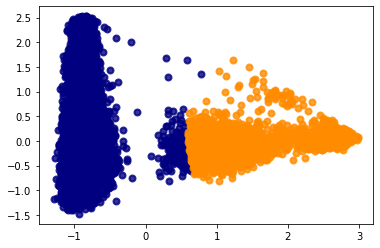

In [21]:
plt.rcParams["figure.figsize"] = (6,4)
plt.figure()

colors = ['navy', 'darkorange'] # 'turquoise', 
target_names = list(range(len(colors)))
lw = 2
for color, i, target_name in zip(colors, list(range(len(target_names))), target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)

In [50]:
original_results = []
with torch.no_grad():
    for idx, batch in enumerate(eval_dataloader):
        src_inputs = batch['src']
        tmp = batch['tmt']
        inputs, target = batch['tgt'][:, :-1], batch['tgt'][:, 1:]
        users = batch['users']
        non_empty_users = users != -1
        if cfg.CUDA:
            src_inputs = src_inputs[non_empty_users].cuda()
            target = target[non_empty_users].cuda()
            tmp = tmp[non_empty_users].cuda()
            inputs = inputs[non_empty_users].cuda()
            users = users[non_empty_users].cuda()

        if non_empty_users.sum() > 0 and idx > 1:
            print('found')
            break

    desc_outputs, desc_latent, desc_mean, desc_std = model.encode_desc(src_inputs)
    tmp_outputs, tmp_latent = model.encode_tmp(tmp)
    user_embeddings = model.user_embedding( users )
    _, output_title = model.decode(tmp_latent, desc_latent, user_embeddings, 
            desc_outputs, tmp_outputs,
            max_length=target.shape[1])
    
    for idx, sent_token in enumerate(batch['tgt'][non_empty_users, 1:]):
        print(idx)
        reference= []
        for token in sent_token:
            if token.item() == Constants.EOS:
                break
            reference.append(valid_dataset.tokenizer.idx2word[token.item()] )
        reference = ''.join(reference)

        sent = output_title[idx]
        sentence = []
        for token in sent:
            if token.item() == Constants.EOS:
                break
            sentence.append(valid_dataset.tokenizer.idx2word[token.item()])
        gen_title = ''.join(sentence)

        sent = tmp[idx][1:]
        sentence = []
        for token in sent:
            if token.item() == Constants.EOS:
                break
            sentence.append(valid_dataset.tokenizer.idx2word[token.item()])

        article = []
        for token in src_inputs[idx][1:]:
            if token.item() == Constants.EOS:
                break
            article.append(valid_dataset.tokenizer.idx2word[token.item()])
        
        result = {
            'generate': gen_title,
            'original': reference,
            'input_user': id2user[users[idx].item()],
            'article': ''.join(article),
            'template': ''.join(sentence).replace('舊', '##')
        }
        original_results.append(result)

found
0
1
2
3
4
5
6
7
8
9
10
11


In [51]:
non_bracket_label = 1
swap_results = []
for start_idx in range(0, 48, 6):
    print(start_idx)
    # start_idx = 0
    no_bracket_latent = X[y==non_bracket_label][start_idx:start_idx+6]
    no_bracket_latent_out = temp_outputs[y==non_bracket_label][start_idx:start_idx+6]
    swap_templates = title[y==non_bracket_label][start_idx:start_idx+6]

    output_titles = []

    for idx, (_latent, _latent_output) in enumerate(zip(no_bracket_latent, temp_outputs)):
        _latent = torch.from_numpy(_latent).view(1, latent_dim * categorical_dim).cuda()
        _latent_output = torch.from_numpy(_latent_output).unsqueeze(0).cuda()
        _, output_title = model.decode(
                _latent,
                desc_latent[[idx]], user2_embeddings[[idx]], 
                desc_outputs[[idx]], _latent_output,
                max_length=target.shape[1])
        output_titles.append(output_title.cpu())

    output_titles = torch.cat(output_titles)
    for idx, sent in enumerate(output_titles):
        sentence = []
        for token in sent:
            if token.item() == Constants.EOS:
                break
            sentence.append(valid_dataset.tokenizer.idx2word[token.item()])
        new_sent = ''.join(sentence[:50]).strip()
        origin_sent = original_sentences[idx]

        if '【' not in new_sent and '【'  in origin_sent:
            print('target template   %s' % swap_templates[idx])
            print('origin gen title %s ' % origin_sent)
            print('new gen title    %s\n' % new_sent)
            swap_results.append({
                '換了template後': new_sent,
                '原來生成的標題': original_results[idx]['generate'],
                '更換 template': templates[idx],
                '原來 template': original_results[idx]['template'],
                'article': original_results[idx]['article'],
                'user_id': original_results[idx]['input_user']
            })
            
#     print("{:<40} | {:>}".format('user: '+ id2user[users2[idx].item()] , ''.join(sentence[:50]).strip(), ))

0
target template   邁阿密機場到市區飯店接送（共乘）
origin gen title 【舊舊一日遊】舊、舊、舊（舊出發） 
new gen title    吉隆坡吉隆坡專屬接送（吉隆坡－雲頂）單程接送）

target template   北海道賞花＆羊蹄山賞芝櫻自採草莓吃到飽
origin gen title 【星光熠熠】舊舊夫人舊門票 
new gen title    雪梨鐵道通行證（《11通行證SydneyExplorerPass）

target template   米爾福德峽灣巡遊與皮划艇之旅
origin gen title 【舊出發】舊＋舊＋慶州賞櫻勝地二日遊 
new gen title    東京東京武士體驗・舉起做武士的武士體驗

6
target template   新天鵝堡全日遊
origin gen title 【舊舊一日遊】舊、舊、舊（舊出發） 
new gen title    吉隆坡吉隆坡專屬接送（吉隆坡－雲頂）單程接送）

target template   普吉島卡圖高空彈跳體驗
origin gen title 【星光熠熠】舊舊夫人舊門票 
new gen title    雪梨鐵道通行證（五11通行證SydneyExplorerPass）

target template   《豪斯登堡住宿》阿姆斯特丹大飯店HotelAmsterdam2人住宿（設計師房型／禁煙）
origin gen title 【舊出發】舊＋舊＋慶州賞櫻勝地二日遊 
new gen title    東京東京武士體驗・舉起做武士的武士體驗

12
target template   大峽谷直升飛機著陸之旅
origin gen title 【舊舊一日遊】舊、舊、舊（舊出發） 
new gen title    吉隆坡吉隆坡專屬接送（吉隆坡－雲頂）單程接送）

target template   在日落時分騎馬，體驗西部荒原的牛仔生活
origin gen title 【星光熠熠】舊舊夫人舊門票 
new gen title    雪梨鐵道通行證（《11通行證SydneyExplorerPass）

18
target template   聖奧古斯丁觀光巴士，探索這座歷史名城（含門票）
origin gen title 【舊

In [54]:
import json
with open('swap_results_'+log_name.replace('/','_')+checkpoint+'.jsonl', 'w') as f:
    for result in good_swap_results:
        f.write(json.dumps(result)+'\n')

In [53]:
if len(swap_results) > 0:
    good_swap_results += swap_results

In [48]:
good_swap_results = []

In [ ]:
print(title[y==0][:60])

In [ ]:
print(title[y==1][:60])

In [97]:
tmp_latent = X[y==1].mean(axis=0)

In [39]:
control_latent = torch.stack([torch.from_numpy(tmp_latent)]*10)

In [29]:
print(title[y==0][:10])

['【Disneyland】美國加州迪士尼樂園門票（電子一日券）' '【東京夜景】六本木之丘展望台門票（TokyoCityView）森美術館'
 '【龍尾灣生態體驗】搭竹筏＋抓螃蟹＋做蠟染（含馬來午餐）' '【仙本那紅樹林】探索長鼻猴與螢火蟲半日遊'
 '【東京賞櫻推薦】隅田川賞櫻遊船票（附賞花便當或點心）' '【胡志明市特色一日遊】古芝地道、胡志明市區觀光導覽'
 '【澳門美獅美高梅酒店】</UNK>・JaniceWongMGM午餐套餐/下午茶套餐' '【普吉唯一友善大象營】親密互動半日體驗'
 '【日本傳統文化】搭屋形船觀賞長</UNK>魚・泡溫泉品嚐</UNK>料理大阪出發)' '【到海底看珊瑚礁】墾丁後壁湖半潛艇航程']


In [44]:
print(title[y==2][:10])

['【柬埔寨最受矚目劇團】法爾，柬埔寨馬戲團Phare,theCambodiaCircus' '雅典城市通票：免費入場和免費遊覽'
 '伊瓜蘇生物中心參觀' '在日落時分騎馬，體驗西部荒原的牛仔生活' '斯德哥爾摩隨上隨下觀光巴士與小船旅遊'
 '聖薩爾瓦多：5小時中轉城市與火山之旅' '曼哈頓島豪華直升機旅遊' '波士頓的歷史之路®徒步遊' '布魯塞爾：布魯日一日旅遊連4小時導覽徒步遊'
 '柏林：1小時馬車夜遊柏林']


In [31]:
print(title[y==3][:10])

['【熱門景點包車一日遊】石門水庫、鎮瀾宮、台中麗寶Outlet（台北出發、台中結束）' '【中文導覽】馬來西亞機場市區優質接送（含WiFi熱點）'
 '【名古屋出發一人成行】閃耀冬季！名花之里．冬季霓虹燈秀，還有午餐甜點吃到飽' '【超值沙巴跳島】沙比島和馬穆迪島一日遊'
 '【經典花蓮必遊】太魯閣奇景拼車一日遊（保證有位）' '【熱門景點包車一日遊】鶯歌老街、新豐紅樹林、彩虹眷村、秋紅谷（台北出發）'
 '自採超甜草莓・螃蟹吃到飽＆滑雪場玩雪東京出發)' '女性限定一人行！一次遊走日本香川、岡山、德島三縣市美術館充滿藝術氣質二日遊！'
 '【小團划算】桃園機場臺北市區接機服務（七人座）' '【乘船遊小金門秘境】船遊戰地史蹟烈嶼7島（</UNK>碼頭出發）']


# Unrelated old code

In [61]:
assert os.path.exists(os.path.join(log_name, 'vmt.py')) == True
print(os.path.join(log_name, checkpoint_name))
assert os.path.exists(os.path.join(log_name, checkpoint_name)) == True

copyfile(os.path.join(log_name, 'vmt.py'), 'module/temp_vmt.py')
checkpoint = torch.load(os.path.join(log_name, checkpoint_name))

from module.temp_vmt import VMT, TemplateD

# checkpoint should contain model state dict,
with open(os.path.join(log_name, 'params.json'), 'r') as f:
    params = json.load(f)
args = Struct(**params)
dataset =  KKDayUser(-1, 'data/kkday_dataset/user_data', 
            'data/kkday_dataset/matrix_factorized_64.pkl',
            prefix='item_graph', embedding=None, max_length=args.max_seq_len, force_fix_len=args.grad_penalty or args.full_text, 
            token_level=args.tokenize, is_train=True)
dataloader = torch.utils.data.DataLoader(dataset, num_workers=4,
                collate_fn=seq_collate, batch_size=64, shuffle=True)
model = VMT(args.gen_embed_dim, dataset.vocab_size,
            enc_hidden_size=128, dec_hidden_size=128, tmp_category=args.tmp_cat_dim,
            tmp_latent_dim=args.tmp_latent_dim, desc_latent_dim=args.desc_latent_dim, user_latent_dim=args.user_latent_dim,
            biset=args.biset,
            max_seq_len=args.max_seq_len-1, gpu=True)

C = VAE_Cluster(64, 64, k_bins=10, output_embed_dim=args.user_latent_dim)

model.load_state_dict(checkpoint['model'])
model = model.cuda().eval()
C = C.cuda().eval()
print(len(dataloader))

save/temp_temp_rec_vae_gan_biset-2020-05-15-16-34-59/amp_checkpoint_80000.pt
3486


In [57]:
template_reference = {}
size = 15000

for i, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
    src_inputs = batch['src']
    tmp = batch['tmp']
    items, users = batch['items'], batch['users']
    inputs, target1 = batch['tgt'][:, :-1], batch['tgt'][:, 1:]
    references = []
    if True:
        inputs, items, users = inputs.cuda(), items.cuda(), users.cuda()
        src_inputs = src_inputs.cuda()
        inputs = inputs.cuda()
        target1 = target1.cuda()
        tmp = tmp.cuda()

    batch_size = src_inputs.shape[0]
#     logits, embed = self.C(items, users)
    desc_outputs, desc_latent, _, _ = model.encode_desc(src_inputs)
    tmp_outputs, tmp_latent = model.encode_tmp(tmp)
#     _, output_title = self.model.decode(tmp_latent, desc_latent, embed,
#             desc_outputs, tmp_outputs,
#             max_length=self.args.max_seq_len)

    # output_title = torch.argmax(output_logits, dim=-1)
    for idx, sent_token in enumerate(batch['tgt'][:, 1:]):
        reference = []
        for token in sent_token:
            if token.item() == Constants.EOS:
                break
            reference.append(dataset.idx2word[token.item()] )
        references.append(reference)
    
    for idx, sent in enumerate(references):
        template_reference[' '.join(sent)] = {
            'tmp': tmp_latent[idx].detach().cpu().numpy(),
            'tmp_outputs': tmp_outputs[idx].detach().cpu(),
            'desc_latent': desc_latent[idx].detach().cpu(),
            'desc_outputs': desc_outputs[idx].detach().cpu(),
        }


/home/theblackcat102/Documents/text-subgan/env/lib/python3.6/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


KeyboardInterrupt: 

In [80]:
from tokenizer import CharTokenizer, WordTokenizer
tokenizers = WordTokenizer()

def generate_text(description, template, user, item):
    with torch.no_grad():
        desc = torch.from_numpy(tokenizers.encode(description)).long().cuda()
        tgt = torch.from_numpy(tokenizers.encode(template)).long().cuda()

        user = torch.from_numpy(user).float().cuda().unsqueeze(0)
        item = torch.from_numpy(item).float().cuda().unsqueeze(0)

        tmp = tgt.unsqueeze(0)[:, :-1]
        src_inputs = desc.unsqueeze(0)
        logits, embed = C(item, user)
        desc_outputs, desc_latent, _, _ = model.encode_desc(src_inputs)
        tmp_outputs, tmp_latent = model.encode_tmp(tmp)
        _, output_title = model.decode(tmp_latent, desc_latent, embed,
                desc_outputs, tmp_outputs,
                max_length=64)

        sentence = []
        for token in output_title[0]:
            if token.item() == Constants.EOS:
                break
            sentence.append(  dataset.idx2word[token.item()])
        return ' '.join(sentence)

In [81]:
log_name = 'save/temp_rec_vae_gan_temp_rand_sample-2020-05-17-12-46-38/'
# log_name = 'save/temp_rec_vae_gan_biset_temp_rand_sample-2020-05-15-03-24-22/'
iteration = 100000
K_BINS = 20
checkpoint_name = 'amp_checkpoint_{}.pt'.format(iteration)
assert os.path.exists(os.path.join(log_name, 'vmt.py')) == True
print(os.path.join(log_name, checkpoint_name))
assert os.path.exists(os.path.join(log_name, checkpoint_name)) == True

copyfile(os.path.join(log_name, 'vmt.py'), 'module/temp_vmt.py')


AssertionError: 

In [ ]:
from module.temp_vmt import VMT, TemplateD
checkpoint = torch.load(os.path.join(log_name, checkpoint_name))
# checkpoint should contain model state dict,
with open(os.path.join(log_name, 'params.json'), 'r') as f:
    params = json.load(f)

args = Struct(**params)

dataset =  KKDayUser(-1, 'data/kkday_dataset/user_data', 
            'data/kkday_dataset/matrix_factorized_64.pkl',
            prefix='item_graph', embedding=None, max_length=args.max_seq_len, force_fix_len=args.grad_penalty or args.full_text, 
            token_level=args.tokenize, is_train=True)
dataloader = torch.utils.data.DataLoader(dataset, num_workers=4,
                collate_fn=seq_collate, batch_size=64, shuffle=True)

model = VMT(args.gen_embed_dim, dataset.vocab_size,
            enc_hidden_size=128, dec_hidden_size=128, tmp_category=args.tmp_cat_dim,
            tmp_latent_dim=args.tmp_latent_dim, desc_latent_dim=args.desc_latent_dim, user_latent_dim=args.user_latent_dim,
            biset=args.biset,
            max_seq_len=args.max_seq_len-1, gpu=True)

C = VAE_Cluster(64, 64, k_bins=10, output_embed_dim=args.user_latent_dim)

model.load_state_dict(checkpoint['model'])
model = model.cuda().eval()
C = C.cuda().eval()

In [ ]:
template_reference = {}
size = 15000

for i, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
    src_inputs = batch['src']
    tmp = batch['tmp']
    items, users = batch['items'], batch['users']
    inputs, target1 = batch['tgt'][:, :-1], batch['tgt'][:, 1:]
    references = []
    if True:
        inputs, items, users = inputs.cuda(), items.cuda(), users.cuda()
        src_inputs = src_inputs.cuda()
        inputs = inputs.cuda()
        target1 = target1.cuda()
        tmp = tmp.cuda()

    batch_size = src_inputs.shape[0]
    desc_outputs, desc_latent, _, _ = model.encode_desc(src_inputs)
    _, tmp_latent = model.encode_tmp(tmp)
    # output_title = torch.argmax(output_logits, dim=-1)
    for idx, sent_token in enumerate(batch['tgt'][:, 1:]):
        reference = []
        for token in sent_token:
            if token.item() == Constants.EOS:
                break
            reference.append(dataset.idx2word[token.item()] )
        references.append(reference)

    for idx, sent in enumerate(references):
        template_reference[' '.join(sent)] = {
            'tmp': tmp_latent[idx].detach().cpu().numpy(),
#             'tmp_outputs': tmp_outputs[idx],
            'desc_latent': desc_latent[idx].detach().cpu(),
            'desc_outputs': desc_outputs[idx].detach().cpu(),
        }


In [ ]:
X, title = [], []
print(len(template_reference))
for key, latent in template_reference.items():
    X.append(latent['tmp'])
    title.append(key)
title = np.array(title)

pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

nbrs = SpectralClustering(n_clusters=6).fit(X_r)

y = nbrs.labels_
print(set(y))

In [ ]:
plt.figure()
target_names = [0,1,2,3,4, 5]

colors = ['navy', 'turquoise', 'darkorange','red','black', 'green']
lw = 2

for color, i, target_name in zip(colors, list(range(len(target_names))), target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)

In [ ]:
for target_name in target_names:
    print(target_name, len(title[y==target_name]))
    print('\n'.join(title[y==target_name][:10]))
    print('')

In [297]:
train_dataset = torch.load('dataset/train.pt')

In [ ]:
valid_dataset = torch.load('dataset/valid.pt')
valid_dataset = torch.load('dataset/test.pt')

In [306]:
valid_user_prod = [ ]
for row in valid_dataset:
    pairs = row[-1]
    for pair in pairs:
        valid_user_prod.append(pair)

for row in tqdm(train_dataset):
    _, _, _, user_prod_pairs = row
    for pair in tqdm(user_prod_pairs):
        if pair in valid_user_prod:
            print('found repeated')
            print(pair)
            break

/home/theblackcat102/Documents/text-subgan/env/lib/python3.6/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


/home/theblackcat102/Documents/text-subgan/env/lib/python3.6/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



KeyboardInterrupt: 

[1266, 15759]
